# Siamese network for bearing fault classification

The goal of this notebook is to train a classification model for bearing faults of rotating equipment. We want this model to be robust to different operating conditions, such as different machine loads or rotation velocity. Moreover, the model must not use characteristic information about the machine, such as the rotation velocity or the characteristic coefficients. For this reason, we will follow a Deep Learning approach.

The model consists of a Convolutional Neural Network splitted into two parts:

+ **The embedding**: It extracts valuable features from the training data, which will be then fed to the classifier. This embedding is trained using a siamese network, which ensures that the extracted features are robust to different operating conditions.

+ **The classifier**: It takes as input the features extracted from the embedding and returns the type of fault of the bearing. It is trained using the typical cross entropy loss. 

In this notebook we will train the model using data from two datasets:

+ **IMS Nasa Bearing Data Center:** This dataset contains the time evolution of different bearings. At the end of the tests, some of these bearings suffer from faults. The goal of using this dataset is to be able to detect failures at early stages, that is, before they have been fully developed. For this reason, the waveform time series will be labeled using the Autoencoder Model, so that waveforms with early development of the failure will be labeled as being unhealthy. This data will be used in the training phase, so that the classification model will learn to detect early failure modes. 

+ **Paderborn Data Center**: This dataset also contains vibration data (waveforms) of different bearings, each suffering from a fault (inner ring, outer ring) or being healthy. The fault is completely developed.

We will mix the data from the two datasets in order to have different operating conditions for the different failures. 

Waveforms will be used as input for the classification model. Such waveforms will be previously preprocessed. In order to do so, we will apply a rolling window (with no overlap) that will split the long time series into smaller ones of 1000 data points. Also, the waveforms will be downsapled into 5000 Hz, which is the usual sampling frequency of real data. Finally, adaptive normalization will be applied. 

More details about the training process are provided in the following sections.


In the following lines we connect to google drive and to import the needed packages.

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import sys

import plotly
from plotly.graph_objs import graph_objs as go

from plotly.offline import iplot
from sklearn import metrics

import random


import umap

sys.path.append('./Training')
sys.path.append('./Data')
sys.path.append('./Load_Data')
sys.path.append('./Models')
sys.path.append('./Preprocessing')

from IMS_data import Import_Data_IMS, Preprocessing_IMS
from envelope import envl_freq
from Paderborn_data import Import_Data_Pad, Preprocessing_Pad, Load_Pad
from train_siamese import Bearings_Network

Using TensorFlow backend.


## Load Paderborn data

Paderborn data contains time series of the vibration of rotating equipment (bearings). It contains two different rotation speeds (900 rpm and 1500 rpm). The dataset contains data from healthy bearings, and from two different types of faults: inner ring fault and outer ring fault. The faults are completely developed at the beginning of the time series.  


In [2]:
data_Pad = Import_Data_Pad('Data/Paderborn/K001/N15/', 'Data/Paderborn/K001/N09/', 'Data/Paderborn/KI01/N15/', 
                       'Data/Paderborn/KI01/N09/', 'Data/Paderborn/KA01/N15/', 'Data/Paderborn/KA01/N09/')

## Preprocessing

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real productio data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Adding noise 

+ Shuffle samples.

+ Split of training and test sets.

The noise is introduced in two different ways:

+ Amplify the amplitude of the 4rth first harmonics.

+ Introduce white noise (random frequencies and amplitudes) within a frequency band of 750-1000Hz.

We add noise so that the data resembles more to real data. 

### Preprocess Paderborn University Data

Given the file names of the data, the following class imports and processes the data in order to make it suitable for the CNN model. 

In [3]:
#Create preprocessing object
prep = Preprocessing_Pad()

#Load Paderborn data
load_Pad = Load_Pad(prep, data_Pad.healthy_files09, data_Pad.healthy_files15,data_Pad.inner_files09,
                     data_Pad.inner_files15,data_Pad.outer_files09, data_Pad.outer_files15)

X_train_Pad, X_test_Pad, y_train_Pad, y_test_Pad, load_train_Pad, load_test_Pad = load_Pad.get_X_y()

Data/Paderborn/K001/N09/N09_M07_F10_K001_1.mat


./Load_Data\Paderborn_data.py:264: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


./Load_Data\Paderborn_data.py:266: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Data/Paderborn/K001/N09/N09_M07_F10_K001_10.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_11.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_12.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_13.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_14.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_15.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_16.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_17.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_18.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_19.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_2.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_20.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_3.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_4.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_5.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_6.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_7.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_8.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_9.mat
Data/Paderborn/K001/N15/N15_M07_F10_K001_1.mat
Data/Paderborn/K001/N15/N15_M07_F10_K001_10.mat
D

## Visualizing the noise

We have mentioned that we have added noise to the Paderborn dataset so that it resembles more the real data. In the following code, we will give an example to show what the noise looks like, both in the time (waveform) and frequency (spectrum) domain.

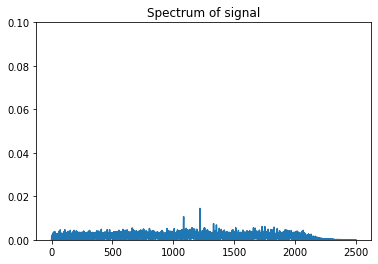

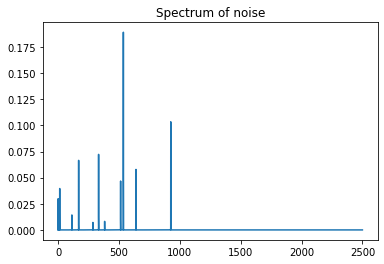

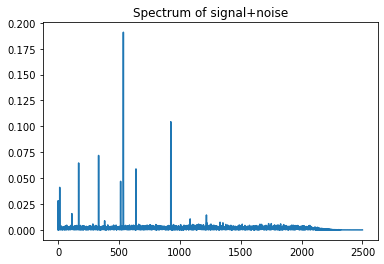

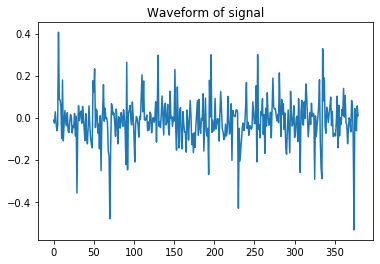

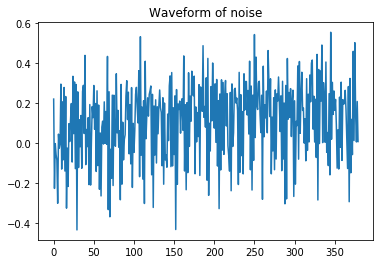

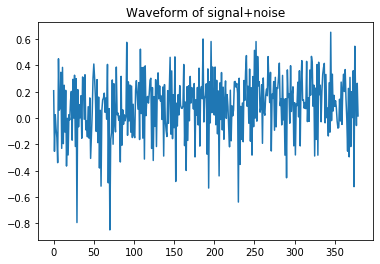

In [6]:
#Prepare the data
file_name = data_Pad.healthy_files15[1]
mat_dict = scipy.io.loadmat(file_name)
try:
    healthy = mat_dict[file_name[24:43]]['Y'][0][0][0][6][2][0]
except:
    healthy = mat_dict[file_name[24:42]]['Y'][0][0][0][6][2][0]
healthy = scipy.signal.decimate(healthy, 12)  # Downsampling to 5000 Hz
vel = float(file_name[21:23])

data = np.copy(healthy)
env = envl_freq(5000, 1800, 2400)

#Prepare the noise and added noise
noise = np.zeros(data.shape)
noise = prep.add_noise_harmonics(noise,vel)
noise = prep.add_noise_band(noise,300000,20000,0,0.08,10,4.0)
data_noise = data + noise

#Show plots

#Spectrum of signal
fft_env, freqs_env, _ = env.acc_spectrum(data, len(data), 5000, cutoff_freq=1)
plt.title('Spectrum of signal')
plt.ylim(0,0.1)
plt.plot(freqs_env, fft_env)
plt.show()

#Spectrum of noise
fft_noise, freqs_noise, _ = env.acc_spectrum(noise, len(noise), 5000, cutoff_freq=1)
plt.plot(freqs_noise, fft_noise)
plt.title('Spectrum of noise')
plt.show()

#Spectrum of signal+noise
fft_env, freqs_env, _ = env.acc_spectrum(data_noise, len(data_noise), 5000, cutoff_freq=1)
plt.title('Spectrum of signal+noise')
plt.plot(freqs_env, fft_env)
plt.show()

#Waveform of signal
plt.plot(range(len(data[range(100,2000,5)])),data[range(100,2000,5)])
plt.title('Waveform of signal')
plt.show()

#Waveform of noise
plt.plot(range(len(noise[range(100,2000,5)])),noise[range(100,2000,5)])
plt.title('Waveform of noise')
plt.show()

#Waveform of signal+noise
plt.plot(range(len(data_noise[range(100,2000,5)])),data_noise[range(100,2000,5)])
plt.title('Waveform of signal+noise')
plt.show()


## Import IMS Data

We import the two files from the IMS Nasa Bearing Data Center. 
The datasets consist of two tests (Test1 and Test2), which contain the waveform time evolution of four bearings. Vibration data is collected with accelerometers. The bearings are of type Rexnord ZA-2115​.

The final state of each of the bearings is the following:

**Test1:**
+ Bearing 1 has an outer race defect which starts at around timestep 800
+ Bearing 2 is healthy
+ Bearing 3 is healthy
+ Bearing 4 has a rolling defect which starts at around timestamp 1800 

**Test2:**
+ Bearing 1 is healthy 
+ Bearing 2 is healthy
+ Bearing 3 has an inner race defect which starts at around timestep 1800
+ Bearing 4 is healthy


In the following class we will import the data from csv files and split it into four dataframes, one for each bearing.

In [8]:
test1 = Import_Data_IMS('Data/IMS/Test_1.csv')
test2 = Import_Data_IMS('Data/IMS/Test_2.csv')

The following lines of code put split the data into being healthy or having a failure (inner ring failure, outer ring failure and rolling element failure). In order to do wo, we use the labels obtained from the Autoencoder model, which tell us approximately in which timestamp the errors start their development.

In [6]:
#Define unhealthy data using the labels from the autoencoder model
inner = test1.t_2[1800:,:]
outer = test2.t_0[800:,:]
rolling = test1.t_3[1800:,:]

#For the healthy data, use waveforms from all tests
#We use a balanced dataset for healthy/unealthy data
idx = np.random.choice(np.arange(1300),70)
healthy1 = test1.t_2[idx,:]
idx = np.random.choice(np.arange(1300),70)
healthy2 = test1.t_3[idx,:]
idx = np.random.choice(np.arange(300),70)
healthy3 = test2.t_0[idx,:]

#Finally, concatenate all the healthy data
healthy  = np.concatenate([healthy1,healthy2,healthy3])

## Preprocessing IMS Data

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real productio data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Shuffle samples.

+ Split of training and test sets.

In [7]:
prep_IMS = Preprocessing_IMS(inner, outer, rolling, healthy)

X_train_IMS, X_test_IMS, y_train_IMS, y_test_IMS = prep_IMS.get_X_y()

## Join datasets

In [8]:
X_train = np.concatenate((X_train_Pad, X_train_IMS), axis=0)
X_test = np.concatenate((X_test_Pad, X_test_IMS), axis=0) 

y_train = np.concatenate((y_train_Pad, y_train_IMS), axis=0) 
y_test = np.concatenate((y_test_Pad,  y_test_IMS), axis=0) 

load_train = np.concatenate((load_train_Pad,  np.repeat(6, y_train_IMS.shape[0])), axis=0)
load_test = np.concatenate((load_test_Pad,  np.repeat(6, y_test_IMS.shape[0])), axis=0) 

Mix everything

In [9]:
#Shuffle indeces so that the loads/defects are not ordered
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx,:]
y_train = y_train[idx]
load_train = load_train[idx]

idx = np.arange(X_test.shape[0])
np.random.shuffle(idx)
X_test = X_test[idx,:]
y_test = y_test[idx]
load_test = load_test[idx]

## Siamese Network

(based on: https://github.com/DataScienceUB/DeepLearningMaster20192020/blob/master/5.%20Keras.ipynb and  https://github.com/fchollet/keras/blob/master/examples/mnist_siamese_graph.py)

The goal of the Siamese network is to create useful embeddings for data points. In our case, the network will learn to map a waveform signal to a point in a lower dimensional space, while trying to minimize the distance between points of the same class and maximize the distance between points of different classes.



Let $X_1$ and $X_2$ be two waveform samples. We feed these samples into the feature network $G_W$ and compute corresponding feature vectors $G_W(X_1)$ and $G_W(X_2)$. The final layer computes pair-wise distance between computed features $E_W = || G_W(X_1) - G_W(X_2) ||_{1}$ and final loss layer $L$ considers whether these two images are from the same class (label $ Y = 1$) or not (label $Y = 0$).

![alt text](https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/siamese1.png?raw=1)


The goal is that $E_W$  is small if $X_1$ and $X_2$ belong to the same class ($Y=1$), and large if they belong to different classes ($Y=0$). The system is trained on pairs of patterns $(X_1,X_2)$ taken from a training set.  The loss function minimized by training minimizes $E_W(X_1, X_2)$ when $X_1$ and $X_2$ are from the same class, and maximizes $E_W(X_1, X_2)$ when they belong to different classes. Note that the same neural network $G_W$ (with the same weights) is used for the two members of the pair $X_1$ and $X_2$. For this reason, the network is called siamese network.

At first glance, we might think that simply minimizing $E_W(X_1, X_2)$ averaged over a set of pairs of inputs from the same class would be sufficient. But this generally leads to a catastrophic collapse: The loss function $\mathcal{L}$ can be made zero by simply making $E_W(X_1, X_2)$ a constant function. Therefore, the loss function needs a contrastive term to ensure not only that the distance $E_W$ for a pair of inputs from the same class is low, but also that the distance $E_W$ for a pair from different classes is large. 

In the original [paper](http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf) it was proposed the **Contrastive Loss Function**: 



$$ 
L(W,(Y,X_1,X_2)^i) = (1 - Y) \times L_S(E_W(X_1,X_2)^i) + Y \times L_D(E_W(X_1,X_2)^i) 
$$

where $L_S$ is the partial loss function for a "same-class" pair and $L_D$ is the partial loss function for a "different-class" pair.

$L_S$ and $L_D$ should be designed in such a way that the minimization of $L$ will decrease the distance in the embedding space of "same-class" pairs and increase it in the case of "different-class" pairs. A simple way to achieve this property is to make $\mathcal{L}_S$ monotonically increasing with $E_W$, and $\mathcal{L}_D$ monotonically decreasing with $E_W$.

$$ L_S = \frac{1}{2} E_W^2 $$
$$ L_D = \frac{1}{2} \{ \mbox{max }(0,1-E_W) \}^2 $$


**References**:

Jordi Vitrià. *Deep Learning Master Repository*. https://github.com/DataScienceUB/DeepLearningMaster20192020/blob/master/. 2019

S. Chopra, R. Hadsell, and Y. LeCun. *Learning a similarity metric discrimi-natively, with application to face verification*. In: 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR’05). 2005, 539–546vol. DOI: 10.1109/CVPR.2005.202 

### Design of the CNN

In order to design a Siamese network, we will use a 1D convolutional neural network as the embedding network. Then, we will add some fully connected layers that will classify the bearing faults based on the embeddings extracted by the CNN. This network will be trained using the contrastive loss function and also the cross entropy loss for classifications. 
 

The CNN has 3 1D Convolutional layers with 32 filters, height=10, strides=1 and padding='same'. We have 3 MaxPooling subsampling layers with pool size = 20, strides = 4. Then we have 1 FC with 256 nodes, one with 128 nodes, and another with 20 output nodes.  All other layers have Relu activation function. This network will extract the embeddings. The classification layer will be a softmax layer with 4 outputs.

We will first pretrain the network using only the classification loss. The performance of this pretrained network will be used as a baseline and will be compared with the same network trained using also contrastive loss. The following class defines the network and allows pretraining and training. 

The following cell pre-trains the CNN model. You can omit this cell and load the saved weights. The training may take some time (around 20min), especially if not using GPU.


In [11]:
pretrain = Bearings_Network(type_net="Pretrain")
pretrain.fit( X_train, y_train, load_train,X_test, y_test, load_test,20, prop =1, save=True,
             patience=10, filepath = "Weights/Siamese/Pretrain.h5", filepath_base = "Weights/Siamese/Pretrain_base.h5")

Creating  Pretrain  Network
Train on 8120 samples, validate on 4712 samples
Epoch 1/20
8120/8120 [==============================] - 46s 6ms/sample - loss: 1.3526 - categorical_accuracy: 0.3238 - val_loss: 1.2264 - val_categorical_accuracy: 0.4219
Epoch 2/20
8120/8120 [==============================] - 44s 5ms/sample - loss: 1.1717 - categorical_accuracy: 0.4330 - val_loss: 1.0551 - val_categorical_accuracy: 0.4788
Epoch 3/20
8120/8120 [==============================] - 47s 6ms/sample - loss: 1.0626 - categorical_accuracy: 0.4762 - val_loss: 0.9755 - val_categorical_accuracy: 0.4813
Epoch 4/20
8120/8120 [==============================] - 44s 5ms/sample - loss: 0.9850 - categorical_accuracy: 0.5176 - val_loss: 0.8857 - val_categorical_accuracy: 0.5327
Epoch 5/20
8120/8120 [==============================] - 44s 5ms/sample - loss: 0.8894 - categorical_accuracy: 0.5717 - val_loss: 0.7510 - val_categorical_accuracy: 0.6621
Epoch 6/20
8120/8120 [==============================] - 44s 5ms/sampl

In [11]:
# Comment these lines if you don't want to load the saved weights

pretrain = Bearings_Network(type_net="Pretrain")
pretrain.load_weights(filepath = "Weights/Siamese/Pretrain.h5", filepath_base = "Weights/Siamese/Pretrain_base.h5", 
                      type_net = "Pretrain" )



Creating  Pretrain  Network


Create Test data

In [12]:
#Test
testX= np.expand_dims(X_test, axis=2)

y_pred = pretrain.model.predict([testX])


Check confusion matrix

In [13]:
matrix = metrics.confusion_matrix(y_test, y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(matrix))
print("Accuracy: " + str(np.sum(np.diag(matrix))/np.sum(matrix)))


Confusion matrix: 
[[574 175   1   0]
 [ 23 734   0 233]
 [303   3 397   2]
 [  0   5   0 585]]
Accuracy: 0.7545304777594728


We observe that the pretraining accuracy is quite good, even though it can be improved.

## Visualization of embeddings: UMAP

We perform a UMAP to visualize the embeddings extracted from the embedding model. 

UMAP is a new technique by McInnes et al. that offers a number of advantages over t-SNE, most notably increased speed and better preservation of the data's global structure. Here we give a glimpse of what this technique does.

### UMAP algorithm

In its simplest sense, the UMAP algorithm consists of two steps: construction of a graph in high dimensions followed by an optimization step to find the most similar graph in lower dimensions.

+ **Step 1: Constructing the high-dimensional graph**: We start by considering our data in a continuous high dimensional space. To determine connectedness, UMAP extends a radius outwards from each point, connecting points when those radii overlap. hoosing this radius is critical - too small a choice will lead to small, isolated clusters, while too large a choice will connect everything together. UMAP overcomes this challenge by choosing a radius locally, based on the distance to each point's nth nearest neighbor. Within this local radius, connectedness is then made “fuzzy” by making each connection a probability, with further points less likely to be connected. Since we don’t want any points to be completely isolated, a constraint is added that all points must be connected to at least its closest neighboring point. The final output of this process is a weighted graph, with edge weights representing the likelihood that two points are “connected” in our high-dimensional manifold.

+ **Step 2: Constructing the low-dimensional graph**: Ideally we want the low dimensional representation to have as similar a fuzzy topological structure as possible. The edges weights between nodes were interpreted as the probability of having a connection. Thus, since both topological structures we are comparing share the same number of nodes, we can imagine that we are comparing the two vectors of probabilities. Given that these are Bernoulli variables (ultimately a connection either exists or it does not, and its probability is the parameter of a Bernoulli distribution), the right choice here is the cross entropy between the weights vectors of the high and low graphs. Therefore, this second phase consists of optimizing the low dimensional graph in terms of the cross entropy measure. 


### UMAP parameters

Now we describe the hyperparameters of the algorithm:

+ **n_neighbors**: the number of nearest neighbors used to construct the initial high-dimensional graph. It effectively controls how UMAP balances local versus global structure - low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

+ **min_dist**: the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

**References**:

High-level explanation: 

+ Adam Pearce Andy Coenen. *Understanding UMAP*. URL:https://pair-code.github.io/understanding-umap/

+ *How UMAP Works*. URL: https://umap-learn.readthedocs.io/en/latest/how_umap_works.html

Original paper: 

+ Leland  McInnes,  John  Healy,  and  James  Melville. *UMAP:  Uniform  ManifoldApproximation  and  Projection  for  Dimension  Reduction*. URL: https://arxiv.org/pdf/1802.03426.


C:\Users\laia.domingo.colomer\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning:

Embedding a total of 10 separate connected components using meta-embedding (experimental)



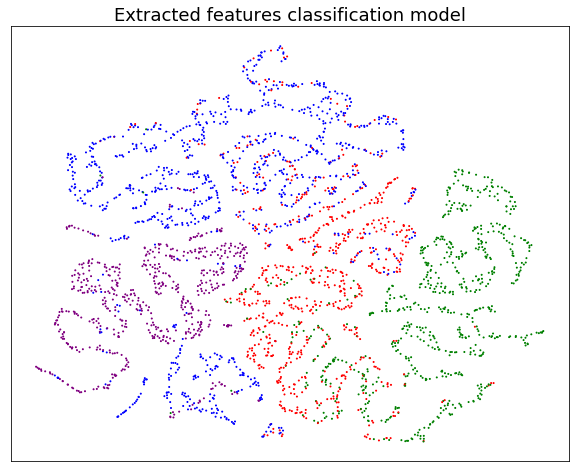

In [14]:
features = pretrain.base_network.predict(testX)

embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.9,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3: 'purple'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embedding[:,0], embedding[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features classification model", fontsize=18)

plt.show()


Te previous figure shows that the embeddings are quite separate. This means that the cross entropy loss already generates good embeddings. We will train the model using Contrastive loss and see if we can improve these embeddings.

Again, you can omit this cell and load the saved weights. The training may take a couple of hours, if not using GPU.

In [27]:
# Comment these lines if you don't want to use the saved weights
siamese= Bearings_Network(type_net="Siamese", base_network = pretrain.base_network)

siamese.fit( X_train, y_train, load_train, X_test, y_test, load_test, 150, patience=10, 
            filepath = "Weights/Siamese/Siamese.h5", filepath_base = "Weights/Siamese/Siamese_base.h5")

Creating  Siamese  Network
Train on 8120 samples, validate on 4712 samples
Epoch 1/150
8120/8120 [==============================] - 52s 6ms/sample - loss: 5.2081 - lambda_5_loss: 0.2471 - dense_13_loss: 1.3696 - dense_14_loss: 1.3670 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.3884 - dense_14_categorical_accuracy: 0.4021 - val_loss: 4.8014 - val_lambda_5_loss: 0.2123 - val_dense_13_loss: 1.3375 - val_dense_14_loss: 1.3329 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.4932 - val_dense_14_categorical_accuracy: 0.5134
Epoch 2/150
8120/8120 [==============================] - 50s 6ms/sample - loss: 4.5255 - lambda_5_loss: 0.1920 - dense_13_loss: 1.3043 - dense_14_loss: 1.3011 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.5909 - dense_14_categorical_accuracy: 0.5400 - val_loss: 3.7366 - val_lambda_5_loss: 0.1226 - val_dense_13_loss: 1.2532 - val_dense_14_loss: 1.2507 - val_lambda_5_categorical_ac

Epoch 17/150
8120/8120 [==============================] - 52s 6ms/sample - loss: 1.5107 - lambda_5_loss: 0.0856 - dense_13_loss: 0.3247 - dense_14_loss: 0.3307 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9454 - dense_14_categorical_accuracy: 0.9429 - val_loss: 0.7982 - val_lambda_5_loss: 0.0288 - val_dense_13_loss: 0.2536 - val_dense_14_loss: 0.2552 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9724 - val_dense_14_categorical_accuracy: 0.9718
Epoch 18/150
8120/8120 [==============================] - 54s 7ms/sample - loss: 1.3152 - lambda_5_loss: 0.0758 - dense_13_loss: 0.2810 - dense_14_loss: 0.2764 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9608 - dense_14_categorical_accuracy: 0.9650 - val_loss: 0.7718 - val_lambda_5_loss: 0.0292 - val_dense_13_loss: 0.2382 - val_dense_14_loss: 0.2400 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9699 - val_dense_14

Epoch 33/150
8120/8120 [==============================] - 51s 6ms/sample - loss: 0.8313 - lambda_5_loss: 0.0607 - dense_13_loss: 0.1111 - dense_14_loss: 0.1128 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9873 - dense_14_categorical_accuracy: 0.9885 - val_loss: 0.5679 - val_lambda_5_loss: 0.0303 - val_dense_13_loss: 0.1299 - val_dense_14_loss: 0.1328 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9694 - val_dense_14_categorical_accuracy: 0.9690
Epoch 34/150
8120/8120 [==============================] - 53s 7ms/sample - loss: 0.8045 - lambda_5_loss: 0.0587 - dense_13_loss: 0.1099 - dense_14_loss: 0.1081 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9865 - dense_14_categorical_accuracy: 0.9879 - val_loss: 0.4973 - val_lambda_5_loss: 0.0268 - val_dense_13_loss: 0.1125 - val_dense_14_loss: 0.1152 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9784 - val_dense_14

Epoch 49/150
8120/8120 [==============================] - 54s 7ms/sample - loss: 0.6407 - lambda_5_loss: 0.0525 - dense_13_loss: 0.0568 - dense_14_loss: 0.0587 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9959 - dense_14_categorical_accuracy: 0.9937 - val_loss: 0.5279 - val_lambda_5_loss: 0.0307 - val_dense_13_loss: 0.1090 - val_dense_14_loss: 0.1102 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9775 - val_dense_14_categorical_accuracy: 0.9773
Epoch 50/150
8120/8120 [==============================] - 52s 6ms/sample - loss: 0.6608 - lambda_5_loss: 0.0543 - dense_13_loss: 0.0593 - dense_14_loss: 0.0580 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9933 - dense_14_categorical_accuracy: 0.9943 - val_loss: 0.5201 - val_lambda_5_loss: 0.0299 - val_dense_13_loss: 0.1091 - val_dense_14_loss: 0.1108 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9767 - val_dense_14

Epoch 65/150
8120/8120 [==============================] - 53s 7ms/sample - loss: 0.7055 - lambda_5_loss: 0.0565 - dense_13_loss: 0.0658 - dense_14_loss: 0.0747 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9867 - dense_14_categorical_accuracy: 0.9846 - val_loss: 0.5206 - val_lambda_5_loss: 0.0303 - val_dense_13_loss: 0.1073 - val_dense_14_loss: 0.1089 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9728 - val_dense_14_categorical_accuracy: 0.9737
Epoch 66/150
8120/8120 [==============================] - 54s 7ms/sample - loss: 0.6172 - lambda_5_loss: 0.0524 - dense_13_loss: 0.0431 - dense_14_loss: 0.0498 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9935 - dense_14_categorical_accuracy: 0.9917 - val_loss: 0.6047 - val_lambda_5_loss: 0.0351 - val_dense_13_loss: 0.1258 - val_dense_14_loss: 0.1257 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9733 - val_dense_14

Epoch 81/150
8120/8120 [==============================] - 53s 6ms/sample - loss: 0.6258 - lambda_5_loss: 0.0539 - dense_13_loss: 0.0435 - dense_14_loss: 0.0436 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9925 - dense_14_categorical_accuracy: 0.9914 - val_loss: 0.6527 - val_lambda_5_loss: 0.0356 - val_dense_13_loss: 0.1449 - val_dense_14_loss: 0.1498 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9720 - val_dense_14_categorical_accuracy: 0.9713
Epoch 82/150
8120/8120 [==============================] - 54s 7ms/sample - loss: 0.5835 - lambda_5_loss: 0.0511 - dense_13_loss: 0.0366 - dense_14_loss: 0.0352 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9933 - dense_14_categorical_accuracy: 0.9945 - val_loss: 0.6448 - val_lambda_5_loss: 0.0355 - val_dense_13_loss: 0.1413 - val_dense_14_loss: 0.1464 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9733 - val_dense_14

Epoch 97/150
8120/8120 [==============================] - 51s 6ms/sample - loss: 0.5664 - lambda_5_loss: 0.0500 - dense_13_loss: 0.0344 - dense_14_loss: 0.0320 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9932 - dense_14_categorical_accuracy: 0.9945 - val_loss: 0.6022 - val_lambda_5_loss: 0.0329 - val_dense_13_loss: 0.1330 - val_dense_14_loss: 0.1388 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9762 - val_dense_14_categorical_accuracy: 0.9760
Epoch 98/150
8120/8120 [==============================] - 55s 7ms/sample - loss: 0.5732 - lambda_5_loss: 0.0506 - dense_13_loss: 0.0338 - dense_14_loss: 0.0331 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9936 - dense_14_categorical_accuracy: 0.9935 - val_loss: 0.6039 - val_lambda_5_loss: 0.0329 - val_dense_13_loss: 0.1342 - val_dense_14_loss: 0.1389 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9758 - val_dense_14

Epoch 113/150
8120/8120 [==============================] - 53s 7ms/sample - loss: 0.5628 - lambda_5_loss: 0.0504 - dense_13_loss: 0.0291 - dense_14_loss: 0.0300 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9941 - dense_14_categorical_accuracy: 0.9940 - val_loss: 0.6667 - val_lambda_5_loss: 0.0353 - val_dense_13_loss: 0.1522 - val_dense_14_loss: 0.1590 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9724 - val_dense_14_categorical_accuracy: 0.9720
Epoch 114/150
8120/8120 [==============================] - 50s 6ms/sample - loss: 0.5438 - lambda_5_loss: 0.0489 - dense_13_loss: 0.0263 - dense_14_loss: 0.0287 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9958 - dense_14_categorical_accuracy: 0.9947 - val_loss: 0.6684 - val_lambda_5_loss: 0.0356 - val_dense_13_loss: 0.1517 - val_dense_14_loss: 0.1582 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9728 - val_dense_

Epoch 129/150
8120/8120 [==============================] - 52s 6ms/sample - loss: 0.5781 - lambda_5_loss: 0.0516 - dense_13_loss: 0.0316 - dense_14_loss: 0.0303 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9926 - dense_14_categorical_accuracy: 0.9932 - val_loss: 0.6842 - val_lambda_5_loss: 0.0364 - val_dense_13_loss: 0.1580 - val_dense_14_loss: 0.1605 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9737 - val_dense_14_categorical_accuracy: 0.9733
Epoch 130/150
8120/8120 [==============================] - 54s 7ms/sample - loss: 0.5666 - lambda_5_loss: 0.0507 - dense_13_loss: 0.0295 - dense_14_loss: 0.0298 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9938 - dense_14_categorical_accuracy: 0.9943 - val_loss: 0.6643 - val_lambda_5_loss: 0.0353 - val_dense_13_loss: 0.1534 - val_dense_14_loss: 0.1559 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9737 - val_dense_

Epoch 145/150
8120/8120 [==============================] - 52s 6ms/sample - loss: 0.5553 - lambda_5_loss: 0.0497 - dense_13_loss: 0.0263 - dense_14_loss: 0.0322 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9948 - dense_14_categorical_accuracy: 0.9942 - val_loss: 0.6811 - val_lambda_5_loss: 0.0356 - val_dense_13_loss: 0.1593 - val_dense_14_loss: 0.1634 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9733 - val_dense_14_categorical_accuracy: 0.9716
Epoch 146/150
8120/8120 [==============================] - 52s 6ms/sample - loss: 0.5587 - lambda_5_loss: 0.0500 - dense_13_loss: 0.0321 - dense_14_loss: 0.0261 - lambda_5_categorical_accuracy: 1.0000 - dense_13_categorical_accuracy: 0.9938 - dense_14_categorical_accuracy: 0.9947 - val_loss: 0.6619 - val_lambda_5_loss: 0.0348 - val_dense_13_loss: 0.1544 - val_dense_14_loss: 0.1571 - val_lambda_5_categorical_accuracy: 1.0000 - val_dense_13_categorical_accuracy: 0.9737 - val_dense_

In [15]:
siamese= Bearings_Network(type_net="Siamese", base_network = pretrain.base_network)

siamese.load_weights(filepath = "Weights/Siamese/Siamese.h5", filepath_base = "Weights/Siamese/Siamese_base.h5")


Creating  Siamese  Network


Create Test data

In [16]:
#Test
testX0 = np.expand_dims(X_test, axis=2)

y_pred = siamese.model.predict([testX0,testX0])[1]


Check accuracy + confusion matrix

In [17]:
matrix = metrics.confusion_matrix(y_test, y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(matrix))
print("Accuracy: " + str(np.sum(np.diag(matrix))/np.sum(matrix)))


Confusion matrix: 
[[719  31   0   0]
 [ 45 945   0   0]
 [  1   0 704   0]
 [  0   4   0 586]]
Accuracy: 0.9733113673805601


The accuracy of the model has improved when using the contrastive loss to generate embeddings. This means having good embeddings helps the model to classify better.

### Visualize features using UMAP

Finally, we visualize again the features extracted by the model after training the embeddings with contrastive loss. 

C:\Users\laia.domingo.colomer\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning:

Embedding a total of 5 separate connected components using meta-embedding (experimental)



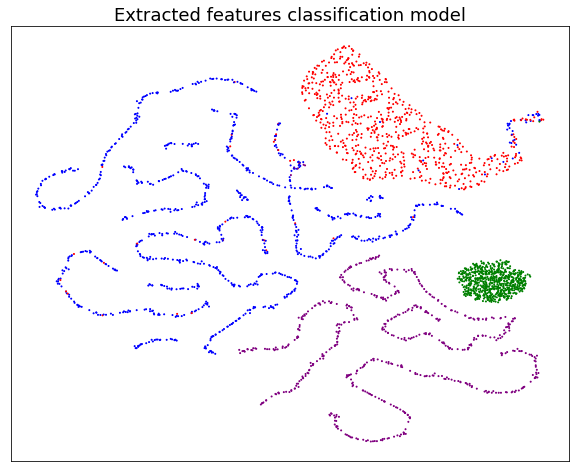

In [19]:
features = siamese.base_network.predict(testX0)

embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.8,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'purple'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embedding[:,0], embedding[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features classification model", fontsize=18)

plt.show()


Observe that after training with the contrastive loss, the embeddings seem to differentiate better the failure modes.